Digit Recognizer (MNIST)
=================================

This is an implementation of [Kaggle competition for recognizing digits](https://www.kaggle.com/c/digit-recognizer)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib notebook

In [2]:
import ImageUtils
import DataUtils

## Loading the dataset

First let's investigate the training dataset, we first read the file, with seperater as `,` and specify that the first row is the header. We can then use the header as our dictionary key

In [3]:
train_data = pd.read_csv('train.csv', sep=',',header=0)
training_labels = train_data['label'].values
training_values = train_data.drop('label', 1).values

evaluation_data = pd.read_csv('test.csv', sep=',',header=0)
evaluation_values = evaluation_data.values

print("There are a total of {} training images".format(len(train_data)))
print("There are a total of {} evaluation images".format(len(evaluation_data)))

training_values = training_values/255
evaluation_values = evaluation_values/255

There are a total of 42000 training images
There are a total of 28000 evaluation images


## Dataset visualization

Now we try to investigate and print some of the data to understand the dataset, we start from index 0 and try every other image

The image is 1
The image is 0
The image is 7


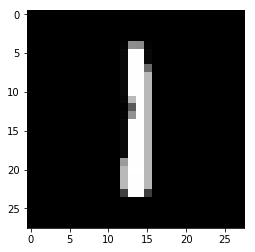

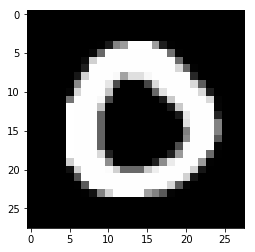

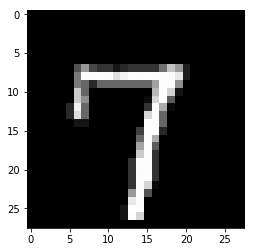

In [4]:
for x in range(2, 8, 2):
    row = DataUtils.reshape_row(training_values[x])
    ImageUtils.show_mnist_image(row)
    print("The image is {}".format(training_labels[x]))

Let's try visualizing the test dataset, we only have test dataset values, but no targets, which means we would have to split out training dataset into test dataset for training the neural network,

The reason why the Kaggel provided test dataset exists, is so that we run the test dataset through our neural network and output the values which would be checked against the test targets (that data is only with Kaggle)

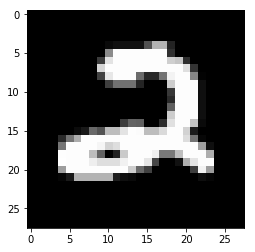

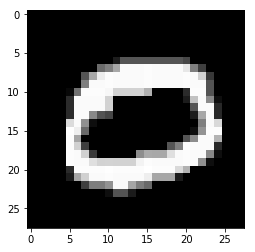

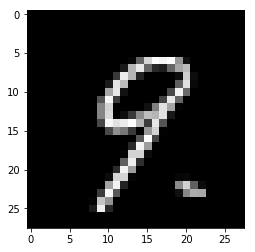

In [5]:
for x in range(0, 3):
    row = DataUtils.reshape_row(evaluation_values[x])
    ImageUtils.show_mnist_image(row)

## One hot encoding the targets

The output target is actual numerical values, so we would need to one hot encode the values

In [6]:
from keras.utils import to_categorical

print("Before one-hot encoding:\n {}".format(training_labels[:10]))

y_train = to_categorical(training_labels)

print("\n\nAfter one-hot encoding:\n {}".format(y_train[:10]))

Using TensorFlow backend.


Before one-hot encoding:
 [1 0 1 4 0 0 7 3 5 3]


After one-hot encoding:
 [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]


## Reshape input images

In [7]:
x_train = training_values.reshape(-1, 28, 28, 1)
print("Shape of training_values {}".format(x_train.shape))

Shape of training_values (42000, 28, 28, 1)


## Creating our Convolution Model

We would be using Keras Sequential layers to generate a model to fit the data

In [8]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten, InputLayer
from keras.optimizers import SGD, Adamax
from keras.losses import categorical_crossentropy
from keras.callbacks import ModelCheckpoint, Callback

model = Sequential()

model.add(InputLayer(input_shape=(28, 28, 1)))
model.add(Conv2D(32, kernel_size=6, strides=1, activation='relu', padding='same'))
model.add(MaxPooling2D(2, 2,padding='same'))
model.add(Dropout(0.6))

model.add(Conv2D(64, kernel_size=6, strides=1, activation='relu', padding='same'))
model.add(MaxPooling2D(2, 2,padding='same'))
model.add(Dropout(0.7))

model.add(Flatten())

model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

model.compile(loss=categorical_crossentropy,
              optimizer=Adamax(lr=0.02),
              metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        1184      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 64)        73792     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 7, 7, 64)          0         
__________

## Training on data

We are splitting the provides training data into training and validation to guide the model towards accuracy. We have to do this because test.csv is not labelled and is only provided for us to predict the values for submission.

In [16]:
from IPython.display import clear_output

class LossHistory(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []

    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
       

checkpoint = ModelCheckpoint("./best.hdf5", monitor='val_acc', save_best_only=True,  mode='max')
history = LossHistory()

model.fit(x_train, y_train, validation_split=0.2, epochs=3, batch_size=64, \
        callbacks=[checkpoint, history])

Train on 33600 samples, validate on 8400 samples
Epoch 1/3
33600/33600 [==============================] - 74s 2ms/step - loss: 0.3904 - acc: 0.8757 - val_loss: 0.2812 - val_acc: 0.9431
Epoch 2/3
33600/33600 [==============================] - 72s 2ms/step - loss: 0.3274 - acc: 0.8974 - val_loss: 0.2822 - val_acc: 0.9390
Epoch 3/3
33600/33600 [==============================] - 69s 2ms/step - loss: 0.2976 - acc: 0.9092 - val_loss: 0.2489 - val_acc: 0.9601


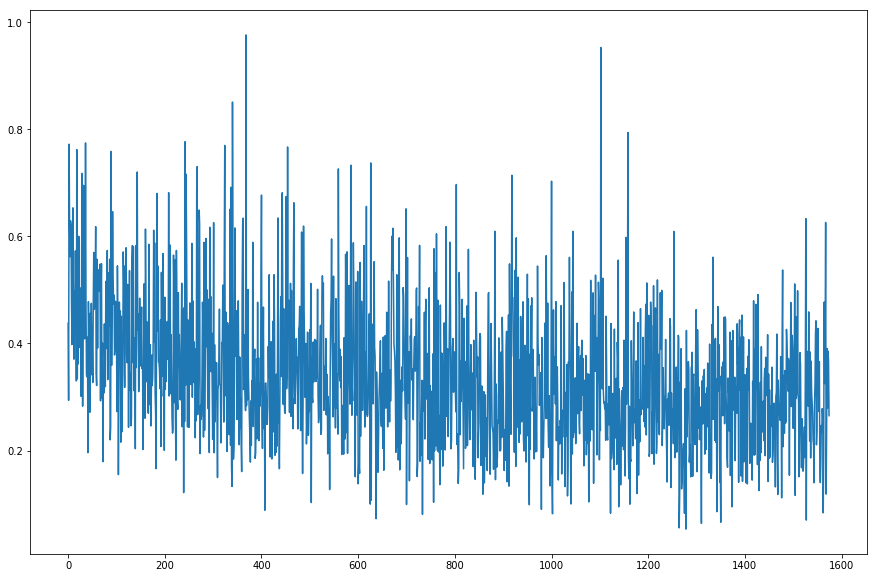

In [17]:
plt.figure(figsize=(15,10))
plt.plot(history.losses)

## Predict on data

Now that we have trained our model, we would take the evaluation data from `train.csv`, reshape it and pass it through the predict method or the model.

Once we get the probability values of each data point, we just end up taking the maximum probability class for each provided data entry.

In [18]:
x_evaluate = evaluation_values.reshape(-1, 28, 28, 1)
y_evaluate = model.predict(x_evaluate)
classes_evaluate = np.argmax(y_evaluate, axis=1)
print(classes_evaluate)

[2 0 9 ... 3 9 2]


## Save the data to csv

We create a dataframe to save our predicted values in the provided csv format for submission.

In [19]:
final_classes=[(idx+1,val) for idx, val in enumerate(classes_evaluate)]

In [20]:
classes_df = pd.DataFrame.from_records(final_classes, columns=['ImageId', 'Label'])
classes_df.tail(10)

,ImageId,Label
27990,27991,7
27991,27992,6
27992,27993,1
27993,27994,9
27994,27995,7
27995,27996,9
27996,27997,7
27997,27998,3
27998,27999,9
27999,28000,2


In [21]:
classes_df.to_csv("mnist-submission.csv", index=False)